### Setup 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import shutil

# Any results you write to the current directory are saved as output.

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np
from sklearn import metrics

C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Data Inspection 

In [4]:
PATH = '../data/driver'

In [5]:
driver_imgs_list_df = pd.read_csv(f'{PATH}/driver_imgs_list.csv')
print(driver_imgs_list_df.head())

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


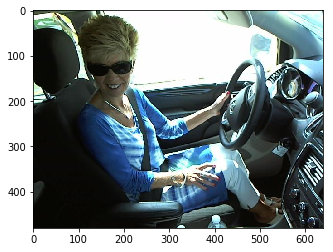

In [6]:
# plt.imread(f'{PATH}/train{}')
img_sample_filename = driver_imgs_list_df.loc[driver_imgs_list_df.count()['img']-1, 'img']
img_sample_classname = driver_imgs_list_df.loc[driver_imgs_list_df.count()['classname']-1, 'classname']
img = plt.imread(f'{PATH}/train/{img_sample_classname}/{img_sample_filename}')
plt.imshow(img)

### Split validation set

In [7]:
driver_list = driver_imgs_list_df.subject.unique()
print(driver_list)

['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p026' 'p035' 'p039' 'p041' 'p042' 'p045' 'p047'
 'p049' 'p050' 'p051' 'p052' 'p056' 'p061' 'p064' 'p066' 'p072' 'p075' 'p081']


In [8]:
def get_val_filenames(val_ration = 0.15):
    train_size = 0
    validation_size = 0
    driver_index = 0
    result = {}
    train_category_filenames = os.listdir(f'{PATH}/train')
    for category in train_category_filenames:
        if category != '.DS_Store':
            filenames = os.listdir(f'{PATH}/train/{category}')
            train_size += len(filenames)
    print(f'Training size: {train_size}')
    
    while (validation_size / train_size) < val_ration:
        driver = driver_list[driver_index]
        for category in train_category_filenames:
            result[category] = result[category] if category in result else []
            if category != '.DS_Store':
                tmp_df = driver_imgs_list_df[(driver_imgs_list_df.subject == driver) & (driver_imgs_list_df.classname == category)]
                result[category] += tmp_df.img.tolist()
                validation_size += tmp_df.img.count()
        driver_index += 1
    print(f'Actual Ratio: {validation_size/train_size}')
    return result

In [9]:
if (not os.path.isdir(f'{PATH}/valid')):
    cat_filename_map = get_val_filenames()
    os.makedirs(f'{PATH}/valid')
    for cat in cat_filename_map:
        os.makedirs(f'{PATH}/valid/{cat}')
        for filename in cat_filename_map[cat]:
            shutil.move(f'{PATH}/train/{cat}/{filename}', f'{PATH}/valid/{cat}/{filename}')

### Train 

In [10]:
arch = resnet34

In [11]:
def get_data(img_size=226, batch_size=64):
    tfms = tfms_from_model(arch, img_size, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_paths(f'{PATH}', batch_size, test_name='test', tfms=tfms)

In [12]:
data = get_data(64)
learn = ConvLearner.pretrained(arch, data)

C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [19]:
learn.lr_find()

 86%|███████████████████████████████████████████████████████████▍         | 243/282 [02:10<00:31,  1.23it/s, loss=9.16]

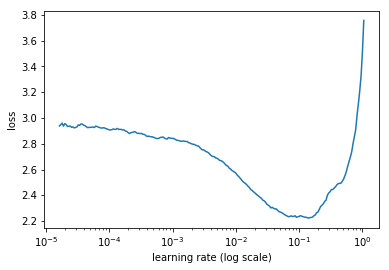

In [20]:
learn.sched.plot()

In [13]:
learning_rate = 2e-2

In [21]:
learn.fit(learning_rate, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.425885   2.582084   0.300434  
    1      1.273146   2.588625   0.295408                                                                              


[2.588624908440947, 0.29540781355561907]

In [22]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
print(metrics.log_loss(y, preds))

2.1977364631454397                                                                                                     


In [23]:
learn.save('driver_last_64')

In [24]:
learn.load('driver_last_64')

In [25]:
learn.unfreeze()

In [14]:
learning_rates = np.array([learning_rate/9, learning_rate/3, learning_rate])

In [27]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.289308   1.949863   0.488005  
    1      0.184586   1.834524   0.519534                                                                              
    2      0.076075   2.023069   0.501942                                                                              
    3      0.11205    2.24174    0.484578                                                                              
    4      0.069075   1.889374   0.5305                                                                                
    5      0.037966   2.376919   0.491661                                                                              
    6      0.040766   2.453897   0.488462                                                                              


[2.453897190987315, 0.4884624171194378]

In [28]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
print(metrics.log_loss(y, preds))

1.7445432385009392                                                                                                     


In [29]:
learn.save('driver_full_64')

In [30]:
learn.load('driver_full_64')

In [20]:
data = get_data(128)
learn.set_data(data)
learn.freeze()

In [32]:
learn.fit(learning_rate, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.744407   2.126075   0.407128  
    1      0.586387   2.17734    0.419465                                                                              


[2.1773396926245407, 0.41946538725154214]

In [33]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
print(metrics.log_loss(y, preds))

1.6533417062170004                                                                                                     


In [34]:
learn.save('driver_last_128')

In [21]:
learn.load('driver_last_128')

In [22]:
learn.unfreeze()

In [23]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.113736   1.357766   0.669408  
    1      0.069437   1.256141   0.670779                                                                              
    2      0.042996   1.289647   0.673064                                                                              
    3      0.048741   1.419772   0.665753                                                                              
    4      0.027994   1.697421   0.658899                                                                              
    5      0.022039   1.558283   0.655472                                                                              
    6      0.018878   1.384377   0.676719                                                                              



[1.3843773021963814, 0.6767192140599487]

In [24]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
print(metrics.log_loss(y, preds))

1.0452253868939259                                                                                                     


In [25]:
learn.save('driver_full_128')

In [26]:
learn.load('driver_full_128')

In [15]:
data = get_data(226)
learn.set_data(data)
learn.freeze()

In [28]:
learn.fit(learning_rate, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.380553   1.729485   0.523189  
    1      0.302095   1.62872    0.547864                                                                              



[1.6287199016409375, 0.5478638335398569]

In [29]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
print(metrics.log_loss(y, preds))

1.1910339691923086                                                                                                     


In [30]:
learn.save('driver_last_226')

In [16]:
learn.load('driver_last_226')

In [17]:
learn.unfreeze()

In [18]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.067353   1.149785   0.663011  
    1      0.043235   1.046275   0.709162                                                                              
    2      0.019952   1.092543   0.688371                                                                              
    3      0.026255   1.332861   0.657985                                                                              
    4      0.021188   1.192702   0.686315                                                                              
    5      0.011152   1.09909    0.69454                                                                               
    6      0.007488   1.17755    0.674206                                                                              



[1.177550470227108, 0.6742060770175761]

In [34]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
print(metrics.log_loss(y, preds))

0.9247961215493619                                                                                                     


In [19]:
learn.save('driver_full_226')

In [33]:
learn.load('driver_full_226')

[[309   0   0   0   0 116   0   0   6  19]
 [ 36 128   0   7   1  11  39   0  90 147]
 [  5   0 418   0   0   1   1   0  41   0]
 [  0   0   0 391  17  17  32   0   6  27]
 [  1   0   0   0 312  52  26   0  96   2]
 [  5   0   0   0   0 451   0   0   8  15]
 [  0   0   0   0   0   0 378   0  86   2]
 [ 20   0   0   0   0  44   0 223  83  33]
 [ 20   0  21   0   7  19  23   0 214  25]
 [ 20   0   1   0   0  60   0   0  14 251]]


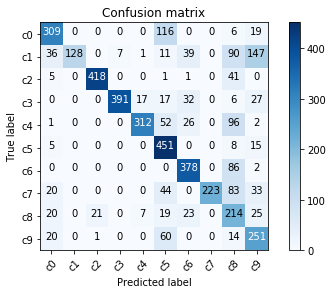

In [40]:
probs = np.argmax(preds, 1)
cm = metrics.confusion_matrix(y, probs)
plot_confusion_matrix(cm, data.classes)

### Submit

In [22]:
log_preds, y = learn.TTA(is_test=True)
preds = np.mean(np.exp(log_preds), 0)

In [24]:
submit_df = pd.DataFrame(preds)
submit_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.000059,3.030556e-06,0.000012,4.302656e-04,1.570785e-05,0.999327,6.362487e-07,0.000060,0.000006,0.000086
1,0.002138,9.748236e-05,0.000027,3.806659e-05,8.180242e-06,0.957538,3.274971e-05,0.000133,0.038561,0.001426
2,0.237099,7.423698e-01,0.000606,9.938131e-03,1.780148e-03,0.001040,2.007148e-03,0.000177,0.001196,0.003786
3,0.000005,3.955256e-07,0.000006,1.466596e-07,2.259028e-07,0.000003,1.599423e-06,0.000021,0.968594,0.031369
4,0.011242,6.025752e-05,0.000010,5.549636e-01,6.113698e-02,0.206591,2.119563e-04,0.000009,0.009687,0.156087


In [25]:
submit_df.columns = data.classes

In [27]:
submit_df.insert(0, 'img', os.listdir(f'{PATH}/test'))

In [28]:
submit_df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.000059,3.030556e-06,0.000012,4.302656e-04,1.570785e-05,0.999327,6.362487e-07,0.000060,0.000006,0.000086
1,img_10.jpg,0.002138,9.748236e-05,0.000027,3.806659e-05,8.180242e-06,0.957538,3.274971e-05,0.000133,0.038561,0.001426
2,img_100.jpg,0.237099,7.423698e-01,0.000606,9.938131e-03,1.780148e-03,0.001040,2.007148e-03,0.000177,0.001196,0.003786
3,img_1000.jpg,0.000005,3.955256e-07,0.000006,1.466596e-07,2.259028e-07,0.000003,1.599423e-06,0.000021,0.968594,0.031369
4,img_100000.jpg,0.011242,6.025752e-05,0.000010,5.549636e-01,6.113698e-02,0.206591,2.119563e-04,0.000009,0.009687,0.156087


In [31]:
submit_df.to_csv(f'submit/driver.gz', index=False, compression="gzip")

In [32]:
FileLink(f'submit/driver.gz')

C:\Users\I863552\Documents\fastai\courses\dl1\kaggle\submit\driver.gz